In [1]:
# Import all necessary libraries
import os
import tensorflow as tf
from tensorflow.keras import mixed_precision
import logging
import warnings
import numpy as np
import matplotlib.pyplot as plt

# Suppress warnings and logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.get_logger().setLevel(logging.ERROR)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)
mixed_precision.set_global_policy('mixed_float16')

# Set seeds for reproducibility
SEED = 1234
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Define constants
IMAGE_SIZE = (224, 224)  # Directly using ResNet50 input size
BATCH_SIZE = 32
EPOCHS = 30
TRAINING_DATA_PATH = "Final_Arabic_Alpha_dataset/train"
TEST_DATA_PATH = "Final_Arabic_Alpha_dataset/test"

# Load datasets
print("Loading datasets...")
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAINING_DATA_PATH,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    label_mode='int'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAINING_DATA_PATH,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    label_mode='int'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DATA_PATH,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    label_mode=None,
    shuffle=False
)

# Get class names
class_names = train_ds.class_names
print(f"Class names: {class_names}")

Loading datasets...
Found 42559 files belonging to 65 classes.
Using 34048 files for training.
Found 42559 files belonging to 65 classes.
Using 8511 files for validation.
Found 10640 files belonging to 1 classes.
Class names: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '7', '8', '9']


In [2]:
# Data augmentation and preprocessing
print("Creating preprocessing pipeline...")
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.2, seed=SEED),
    tf.keras.layers.RandomZoom(0.1, seed=SEED),
])

resnet_preprocess = tf.keras.applications.resnet50.preprocess_input

# Build model
print("Building model...")
base_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(*IMAGE_SIZE, 3)
)

inputs = tf.keras.Input(shape=(*IMAGE_SIZE, 3))
x = data_augmentation(inputs)
x = resnet_preprocess(x)
x = base_model(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax', dtype='float32')(x)

model = tf.keras.Model(inputs, outputs)

# Freeze base model initially
base_model.trainable = False

# Compile model
model.compile(
    optimizer=mixed_precision.LossScaleOptimizer(tf.keras.optimizers.Adam(learning_rate=1e-4), dynamic=True),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

model.summary()

Creating preprocessing pipeline...
Building model...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAv

In [3]:
# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=1e-7
    )
]

# Train model
print("Training model...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

Training model...
Epoch 1/30
1064/1064 [==============================] - 396s 348ms/step - loss: 3.6171 - accuracy: 0.1241 - val_loss: 2.7200 - val_accuracy: 0.3300 - lr: 1.0000e-04
Epoch 2/30
1064/1064 [==============================] - 537s 504ms/step - loss: 2.8316 - accuracy: 0.2547 - val_loss: 2.1068 - val_accuracy: 0.4576 - lr: 1.0000e-04
Epoch 3/30
1064/1064 [==============================] - 501s 471ms/step - loss: 2.4716 - accuracy: 0.3241 - val_loss: 1.8105 - val_accuracy: 0.5303 - lr: 1.0000e-04
Epoch 4/30
1064/1064 [==============================] - 485s 455ms/step - loss: 2.2539 - accuracy: 0.3736 - val_loss: 1.6129 - val_accuracy: 0.5649 - lr: 1.0000e-04
Epoch 5/30
1064/1064 [==============================] - 485s 455ms/step - loss: 2.0901 - accuracy: 0.4095 - val_loss: 1.4879 - val_accuracy: 0.5941 - lr: 1.0000e-04
Epoch 6/30
1064/1064 [==============================] - 474s 446ms/step - loss: 1.9896 - accuracy: 0.4374 - val_loss: 1.3844 - val_accuracy: 0.6257 - lr: 1.0

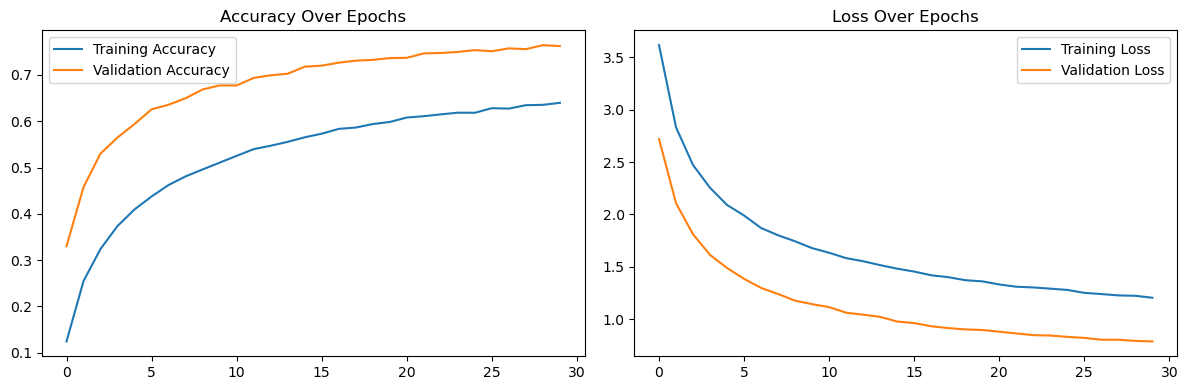

In [4]:
# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_history(history)

In [5]:
# Unfreeze some layers of the base model
fine_tune_at = 100  # Unfreeze from this layer onwards

base_model.trainable = True
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [6]:
# Compile with a lower learning rate
model.compile(
    optimizer=mixed_precision.LossScaleOptimizer(
        tf.keras.optimizers.Adam(learning_rate=1e-5),  # Lower learning rate
        dynamic=True
    ),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [7]:
# Train the model again with fine-tuning
fine_tune_epochs = 10  # Fine-tune for 10 more epochs
total_epochs = EPOCHS + fine_tune_epochs  # Add to previous epochs

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],  # Resume from where we left off
    callbacks=callbacks
)

Epoch 30/40
1064/1064 [==============================] - 403s 369ms/step - loss: 1.3543 - accuracy: 0.5986 - val_loss: 0.5627 - val_accuracy: 0.8272 - lr: 1.0000e-05
Epoch 31/40
1064/1064 [==============================] - 432s 406ms/step - loss: 0.8736 - accuracy: 0.7312 - val_loss: 0.4198 - val_accuracy: 0.8697 - lr: 1.0000e-05
Epoch 32/40
1064/1064 [==============================] - 415s 390ms/step - loss: 0.7138 - accuracy: 0.7795 - val_loss: 0.3548 - val_accuracy: 0.8901 - lr: 1.0000e-05
Epoch 33/40
1064/1064 [==============================] - 418s 393ms/step - loss: 0.6121 - accuracy: 0.8074 - val_loss: 0.3082 - val_accuracy: 0.9042 - lr: 1.0000e-05
Epoch 34/40
1064/1064 [==============================] - 355s 334ms/step - loss: 0.5463 - accuracy: 0.8305 - val_loss: 0.2889 - val_accuracy: 0.9079 - lr: 1.0000e-05
Epoch 35/40
1064/1064 [==============================] - 499s 469ms/step - loss: 0.5013 - accuracy: 0.8396 - val_loss: 0.2603 - val_accuracy: 0.9156 - lr: 1.0000e-05
Epoc

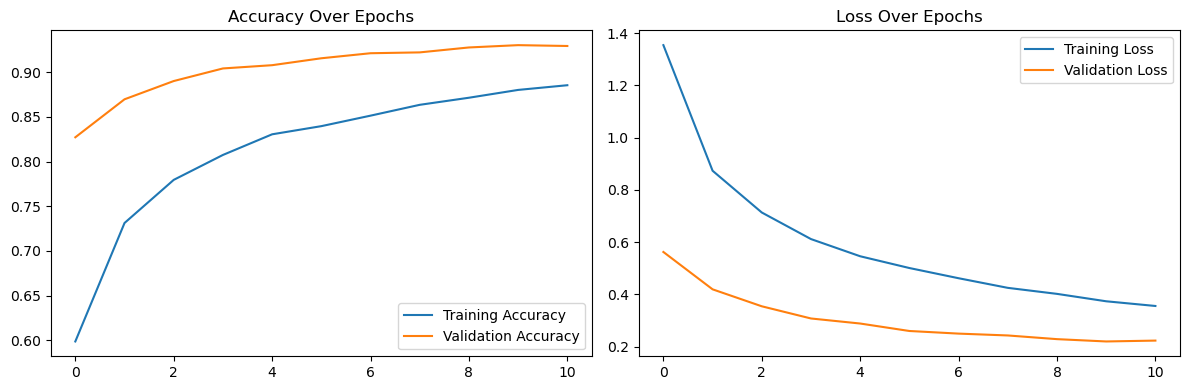

In [8]:
plot_history(history_fine)

In [20]:
# Predict classes for the test dataset
predictions = model.predict(test_ds)

# Convert probabilities to class indices
predicted_classes = np.argmax(predictions, axis=1)

# Map class indices to actual class names
predicted_labels = [class_names[idx] for idx in predicted_classes]

333/333 [==============================] - 17s 50ms/step


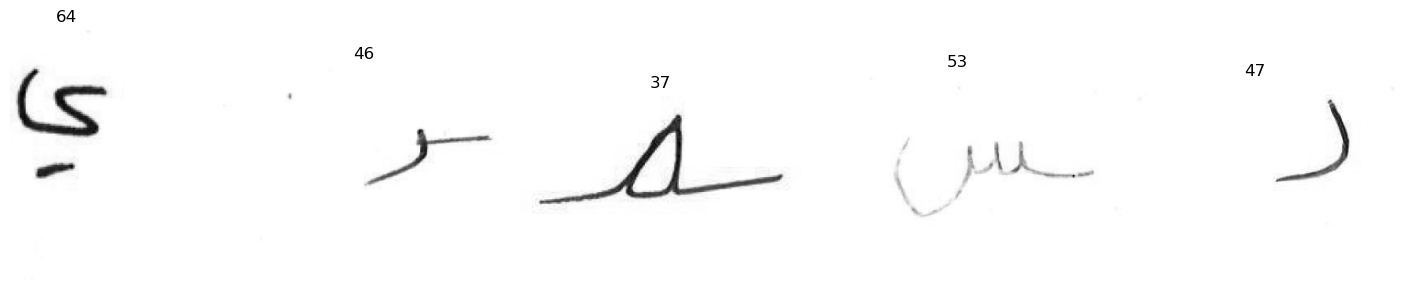

In [23]:
import random

file_paths = test_ds.file_paths

# Choose how many images you want to display
num_samples = 5

# Randomly pick indices from the test set
random_indices = random.sample(range(len(file_paths)), num_samples)

# Plot the chosen images with their predicted classes
plt.figure(figsize=(15, 3))
for i, idx in enumerate(random_indices):
    image = plt.imread(file_paths[idx])
    plt.subplot(1, num_samples, i+1)
    plt.imshow(image, cmap='gray')
    plt.title(predicted_labels[idx])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [24]:
# save Model
model.save("arabic_letter_classifier_89_93")

In [25]:
# Load the model
loaded_model = tf.keras.models.load_model("arabic_letter_classifier_89_93")

In [26]:
# Predict classes with the loaded model
predictions_loaded = loaded_model.predict(test_ds)
predicted_classes_loaded = np.argmax(predictions_loaded, axis=1)
predicted_labels_loaded = [class_names[idx] for idx in predicted_classes_loaded]

333/333 [==============================] - 18s 52ms/step


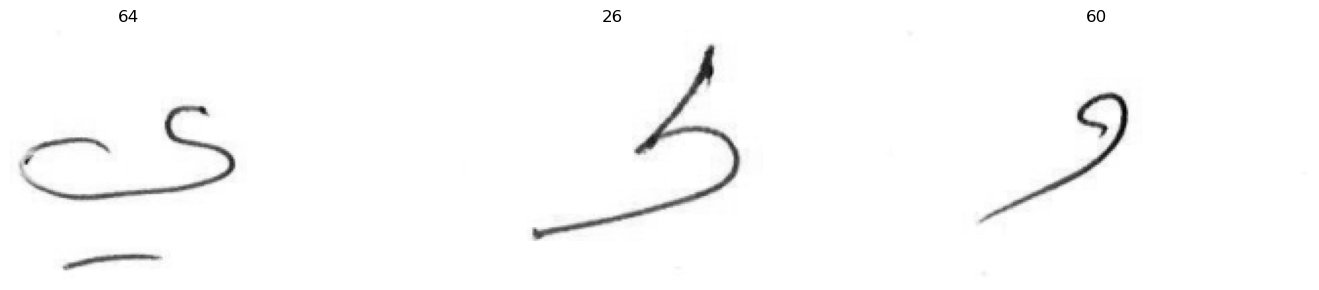

In [27]:
num_samples = 3  # Number of images to display
random_indices = random.sample(range(len(file_paths)), num_samples)

plt.figure(figsize=(15, 3))
for i, idx in enumerate(random_indices):
    image = plt.imread(file_paths[idx])
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(predicted_labels_loaded[idx])
    plt.axis('off')

plt.tight_layout()
plt.show()